In [1]:
import os
import sys
import gc
import json
import random
#fpath = os.path.join(os.getcwd(), 'mobilestereonet', 'datasets')
#sys.path.append(fpath)
from argoverse.data_loading.stereo_dataloader import ArgoverseStereoDataLoader
from argoverse.evaluation.stereo.utils import compute_disparity_error_image
import matplotlib.pyplot as plt
import numpy as np
fpath = os.path.abspath(os.path.join(os.getcwd(), '..'))
fpath_mobilenet = os.path.join(fpath, 'mobilestereonet')
#fpath_utils = os.path.join(fpath, 'utils')
sys.path.append(fpath)
sys.path.append(fpath_mobilenet)
#sys.path.append(fpath_utils)
print(fpath)
from mobilestereonet.models import __models__, model_loss
from mobilestereonet.utils import *
from mobilestereonet.utils.KittiColormap import *
from IPython.display import clear_output

import torch
import torch.optim as optim
import time
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from math import floor
from torch.utils.data import Dataset
from argoverse.utils.camera_stats import RECTIFIED_STEREO_CAMERA_LIST
import torchvision.transforms as transforms

from argoverse.evaluation.stereo.eval import StereoEvaluator
from argoverse.utils.calibration import get_calibration_config
from argoverse.utils.camera_stats import RECTIFIED_STEREO_CAMERA_LIST

from pathlib import Path
from argoverse.evaluation.stereo.utils import compute_disparity_error_image

#import dataset

/home/ubutubiggerbetter/Desktop/249_project/testing_build


In [8]:

#BUild dataset class for the translation between mobilenet and argoverse data
STEREO_FRONT_LEFT_RECT = RECTIFIED_STEREO_CAMERA_LIST[0]
STEREO_FRONT_RIGHT_RECT = RECTIFIED_STEREO_CAMERA_LIST[1]

class ArgoverseDataset(Dataset):
    def __init__(self, data_dir, training, split_name='train', log_ids=["15c802a9-0f0e-3c87-b516-a3fa02f1ecb0"]):

        self.stereo_data_loader = ArgoverseStereoDataLoader(data_dir, split_name)
        self.training = training
        self.left_stereo_img_fpaths = []
        self.right_stereo_img_fpaths = []
        self.disparity_map_fpaths = []
        self.disparity_obj_map_fpaths = []
        for log_id in log_ids:
            if len(self.left_stereo_img_fpaths) == 0:
                self.left_stereo_img_fpaths = self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                    log_id = log_id,
                    camera_name=STEREO_FRONT_LEFT_RECT
                )
                self.right_stereo_img_fpaths = self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                    log_id = log_id, 
                    camera_name = STEREO_FRONT_RIGHT_RECT
                )

                self.disparity_map_fpaths = self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id,
                    disparity_name="stereo_front_left_rect_disparity"
                )

                self.disparity_obj_map_fpaths = self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id, 
                    disparity_name = "stereo_front_left_rect_objects_disparity"
                )
            else:
                self.left_stereo_img_fpaths = self.left_stereo_img_fpaths + self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                        log_id = log_id,
                        camera_name=STEREO_FRONT_LEFT_RECT
                    )
                
                self.right_stereo_img_fpaths = self.right_stereo_img_fpaths + self.stereo_data_loader.get_ordered_log_stereo_image_fpaths(
                    log_id = log_id, 
                    camera_name = STEREO_FRONT_RIGHT_RECT
                )

                self.disparity_map_fpaths = self.disparity_map_fpaths+ self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id,
                    disparity_name="stereo_front_left_rect_disparity"
                )

                self.disparity_obj_map_fpaths = self.disparity_obj_map_fpaths + self.stereo_data_loader.get_ordered_log_disparity_map_fpaths(
                    log_id = log_id, 
                    disparity_name = "stereo_front_left_rect_objects_disparity"
                )

    def load_path(self):
        print('loading path')
        #I believe this returns the paths for desired data
        #optional defintion
    def get_left_image(self, index, cropped=False):
        #Assumes that the cropping is consistent with test functionality
        left_img =  self.stereo_data_loader.get_rectified_stereo_image(self.left_stereo_img_fpaths[index])
        if cropped:
            crop_w, crop_h = 960, 512
            h, w , c = left_img.shape
            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)        
            left_img = left_img[y_start:y_start+crop_h, x_start:x_start+crop_w,:]
        
        return left_img

    def get_right_image(self, index, cropped=False):
        #Assumes that the cropping is consistent with test functionality
        right_img = self.stereo_data_loader.get_rectified_stereo_image(self.right_stereo_img_fpaths[index])
        if cropped:
            crop_w, crop_h = 960, 512
            h, w , c = right_img.shape
            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)        
            right_img = right_img[y_start:y_start+crop_h, x_start:x_start+crop_w,:]

        return right_img

    def get_disparity_image(self, index, cropped=False):
        stereo_front_left_rect_disparity = self.stereo_data_loader.get_disparity_map(self.disparity_map_fpaths[index])
        if cropped:
            crop_w, crop_h = 960, 512
            h, w  = stereo_front_left_rect_disparity.shape
            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)
            stereo_front_left_rect_disparity = stereo_front_left_rect_disparity[y_start:y_start+crop_h, x_start:x_start+crop_w]
        return stereo_front_left_rect_disparity


    def load_disp(self):
        #optinoal again, looks like it reads a depth map or disparity map
        #from a pfm (floating point image map file format), then returns that
        print('Loading disparity')
        
    def __len__(self):
        #specifies the length of the dataset
        return len(self.left_stereo_img_fpaths)
    def get_transform():
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __getitem__(self, index):
        #required function, expected return format of:
        #dictionary, with keys left (leftimg), right (rightimg),
        #   disparity (disparity), top_pad(seems like always 0), 
        #right_pad (seems like always 0), and left_filename (left image filename)
        left_img = self.stereo_data_loader.get_rectified_stereo_image(self.left_stereo_img_fpaths[index])
        right_img = self.stereo_data_loader.get_rectified_stereo_image(self.right_stereo_img_fpaths[index])
        stereo_front_left_rect_disparity = self.stereo_data_loader.get_disparity_map(self.disparity_map_fpaths[index])
        stereo_front_left_rect_objects_disparity = self.stereo_data_loader.get_disparity_map(self.disparity_obj_map_fpaths[index])

        mean = [0.485, 0.456, 0.406]

        std = [0.229, 0.224, 0.225]
        

        if self.training:
            #Need to crop...
            crop_w, crop_h = 512, 256
            h, w , c = left_img.shape
            #some number b/t 0 and all the way to edge (top or right)
            x1 = random.randint(0, w-crop_w)
            y1 = random.randint(0, h - crop_h)

            T = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)])
            
            left_img_t = T(left_img)
            left_img_t = transforms.functional.crop(left_img_t, y1, x1, crop_h, crop_w)
            right_img_t = T(right_img)
            right_img_t = transforms.functional.crop(right_img_t, y1, x1, crop_h, crop_w)
            #print('y1: ', y1, 'y1+crop_h', y1+crop_h, 'x1: ', x1, 'x1+crop_w', x1+crop_w)
            stereo_front_left_rect_disparity = stereo_front_left_rect_disparity[y1:y1+crop_h, x1:x1+crop_w]
            
            return {"left": left_img_t,
                "right": right_img_t,
                "disparity": stereo_front_left_rect_disparity}
        else:
            #Need to crop...
            crop_w, crop_h = 960, 512
            h, w , c = left_img.shape

            x_start = floor((w - crop_w)/2)
            y_start = floor((h - crop_h)/2)
            
            T = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)])

            #center crop:
            left_img_t = T(left_img)
            #print('y_start: ', y_start, 'x_start: ', x_start, 'crop_h: ', crop_h, 'crop_w:', crop_w)
            left_img_t = transforms.functional.crop(left_img_t, y_start, x_start, crop_h, crop_w)
            right_img_t = T(right_img)
            right_img_t = transforms.functional.crop(right_img_t, y_start, x_start, crop_h, crop_w)
            stereo_front_left_rect_disparity = stereo_front_left_rect_disparity[y_start:y_start+crop_h, x_start:x_start+crop_w]
            stereo_front_left_rect_objects_disparity = stereo_front_left_rect_objects_disparity[y_start:y_start+crop_h, x_start:x_start+crop_w]
            tmp_T = transforms.ToTensor()
            left_truth_image = tmp_T(self.get_left_image(index, cropped=True))
            right_truth_image = tmp_T(self.get_right_image(index, cropped=True))
            return {"left": left_img_t,
                "right": right_img_t,
                "disparity": stereo_front_left_rect_disparity,
                "disparity_obj": stereo_front_left_rect_objects_disparity,
                "top_pad": 0,
                "right_pad":0,
                "left_filename": self.left_stereo_img_fpaths[index],
                "left_truth_img": left_truth_image,
                "right_truth_img": right_truth_image}


In [9]:
#the 192 is default max disparity
max_disp = 192
# create summary logger
logdir = '.'
logger = SummaryWriter(logdir)

### The following is for training, if already trained then skip to Test

In [167]:
data_dir = "/media/sf_shared/data"
split_name = "train"
log_ids = ['08a8b7f0-c317-3bdb-b3dc-b7c9b6d033e2', '0ef28d5c-ae34-370b-99e7-6709e1c4b929', '10b3a1d8-e56c-38be-aaf7-ef2f862a5c4e', 
'3138907e-1f8a-362f-8f3d-773f795a0d01',  'c6911883-1843-3727-8eaa-41dc8cda8993',
'3d20ae25-5b29-320d-8bae-f03e9dc177b9',  'cd38ac0b-c5a6-3743-a148-f4f7b804ed17',
'4137e94a-c5da-38bd-ad06-6d57b24bccd0',  'd4d9e91f-0f8e-334d-bd0e-0d062467308a',
'45753856-4575-4575-4575-345754906624',  'dcdcd8b3-0ba1-3218-b2ea-7bb965aad3f0',
'52af191b-ba56-326c-b569-e37790db40f3',  'de777454-df62-3d5a-a1ce-2edb5e5d4922',
'53037376-5303-5303-5303-553038557184',  'e9bb51af-1112-34c2-be3e-7ebe826649b4',
'53213cf0-540b-3b5a-9900-d24d1d41bda0',  'ebe7a98b-d383-343b-96d6-9e681e2c6a36',
'577ea60d-7cc0-34a4-a8ff-0401e5ab9c62',  'f0826a9f-f46e-3c27-97af-87a77f7899cd',
'5c251c22-11b2-3278-835c-0cf3cdee3f44',  'f3fb839e-0aa2-342b-81c3-312b80be44f9',
'649750f3-0163-34eb-a102-7aaf5384eaec',  'fa0b626f-03df-35a0-8447-021088814b8b',
'64c12551-adb9-36e3-a0c1-e43a0e9f3845']


argoverse_ds = ArgoverseDataset(data_dir, True, split_name, log_ids=log_ids)
TrainImgLoader = DataLoader(argoverse_ds, 1, shuffle=False, num_workers = 4)


In [168]:

model = __models__['MSNet2D'](max_disp)
learning_rate = .001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))


In [169]:
def train(TrainImgLoader, start_epoch = 0, epochs = 1, lrepochs= "200:10", summary_freq = 10, 
    train_limit = 100000, max_disp = 192, save_freq = 1):
    
    best_checkpoint_loss = 100
    for epoch_idx in range(start_epoch, epochs):
        adjust_learning_rate(optimizer, epoch_idx, learning_rate, lrepochs)
        for batch_idx, sample in enumerate(TrainImgLoader):
            global_step = len(TrainImgLoader) * epoch_idx + batch_idx
            start_time = time.time()
            do_summary = global_step % summary_freq == 0
            
            loss, scalar_outputs, image_outputs = train_sample(sample, compute_metrics=do_summary, max_disp=max_disp)
            if do_summary:
                save_scalars(logger, 'train', scalar_outputs, global_step)
                save_images(logger, 'train', image_outputs, global_step)
            del scalar_outputs, image_outputs
            print('Epoch {}/{}, Iter {}/{}, train loss = {:.3f}, time = {:.3f}'.format(epoch_idx, epochs,
                                                                                        batch_idx,
                                                                                        len(TrainImgLoader), loss,
                                                                                        time.time() - start_time))
            if batch_idx > train_limit:
                break  
        if (epoch_idx + 1)  % save_freq == 0:
            checkpoint_data = {'epoch': epoch_idx, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
            torch.save(checkpoint_data, "{}/checkpoint_{:0>6}.ckpt".format(logdir, epoch_idx))

        gc.collect()       
               

In [170]:
# train one sample
def train_sample(sample, max_disp = 192, compute_metrics=False):
    model.train()

    imgL, imgR, disp_gt = sample['left'], sample['right'], sample['disparity']

    optimizer.zero_grad()
    disp_ests = model(imgL, imgR)
    mask = (disp_gt < max_disp) & (disp_gt > 0)
    loss = model_loss(disp_ests, disp_gt, mask)

    scalar_outputs = {"loss": loss}
    image_outputs = {"disp_est": disp_ests, "disp_gt": disp_gt, "imgL": imgL, "imgR": imgR}
    if compute_metrics:
        with torch.no_grad():
            image_outputs["errormap"] = [disp_error_image_func(disp_est, disp_gt) for disp_est in disp_ests]
            scalar_outputs["EPE"] = [EPE_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
            scalar_outputs["D1"] = [D1_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
            scalar_outputs["Thres1"] = [Thres_metric(disp_est, disp_gt, mask, 1.0) for disp_est in disp_ests]
            scalar_outputs["Thres2"] = [Thres_metric(disp_est, disp_gt, mask, 2.0) for disp_est in disp_ests]
            scalar_outputs["Thres3"] = [Thres_metric(disp_est, disp_gt, mask, 3.0) for disp_est in disp_ests]
    loss.backward()
    optimizer.step()

    return tensor2float(loss), tensor2float(scalar_outputs), image_outputs

In [ ]:
start_epoch = 0
epochs = 4
lrepochs = "4:10"
summary_freq = 10
save_freq = 1
train(TrainImgLoader, start_epoch = start_epoch, epochs = epochs, lrepochs= lrepochs, summary_freq = summary_freq, 
    max_disp = 192, save_freq = save_freq)

### Test Section

In [10]:

#Reset the model:
model = __models__['MSNet2D'](max_disp)
if torch.cuda.is_available():
    print('Using GPU Device')
    model = nn.DataParallel(model)
    model.cuda()
    #Attempt loading the model from most recent checkpoint


state_dict = torch.load('trained_mobilenet/checkpoint_000003.ckpt')
model.load_state_dict(state_dict['model'])


<All keys matched successfully>

In [11]:
#Create testimgloader (will be same as testset for now)
data_dir = "/media/sf_shared/data"
split_name = "val"
#val_log_ids = "15c802a9-0f0e-3c87-b516-a3fa02f1ecb0"
'''
val_log_ids = \
["00c561b9-2057-358d-82c6-5b06d76cebcf",
"033669d3-3d6b-3d3d-bd93-7985d86653ea",
"1d676737-4110-3f7e-bec0-0c90f74c248f",
"2d12da1d-5238-3870-bfbc-b281d5e8c1a1",
"33737504-3373-3373-3373-633738571776",
"39556000-3955-3955-3955-039557148672",
"5ab2697b-6e3e-3454-a36a-aba2c6f27818",
"64724064-6472-6472-6472-764725145600",
"6db21fda-80cd-3f85-b4a7-0aadeb14724d",
"70d2aea5-dbeb-333d-b21e-76a7f2f1ba1c",
"85bc130b-97ae-37fb-a129-4fc07c80cca7",
"cb0cba51-dfaf-34e9-a0c2-d931404c3dd8",
"cb762bb1-7ce1-3ba5-b53d-13c159b532c8",
"da734d26-8229-383f-b685-8086e58d1e05",
"e9a96218-365b-3ecd-a800-ed2c4c306c78",
"f1008c18-e76e-3c24-adcc-da9858fac145",
"f9fa3960-537f-3151-a1a3-37a9c0d6d7f7"]'''

val_log_ids = ["70d2aea5-dbeb-333d-b21e-76a7f2f1ba1c"]



argoverse_ds_test = ArgoverseDataset(data_dir, False, split_name, log_ids=val_log_ids)
print(len(argoverse_ds_test), 'total data logs within validation set')
#convert to data loader
TestImgLoader = DataLoader(argoverse_ds_test, 1, shuffle=False, num_workers = 4)



1522 total data logs within validation set


In [13]:
def test(img_loader, test_iteration_limit = 100000):
    time_start = time.time()
    print("Generating the disparity maps...")
    timestamp = time.strftime("%m_%d_%Y_%H_%M_%S")
    folder_name = "results_"+timestamp
    results_path = os.path.join("./"+folder_name)
    pred_path = os.path.join(results_path, "predictions")
    truth_path = os.path.join(results_path, "ground_truth", "stereo_front_left_rect_disparity")
    truth_obj_path = os.path.join(results_path, "ground_truth", "stereo_front_left_rect_objects_disparity")
    ref_img_path = os.path.join(results_path, "reference_images")
    os.makedirs(results_path, exist_ok=True)
    os.makedirs(pred_path, exist_ok=True)
    os.makedirs(truth_path, exist_ok=True)
    os.makedirs(truth_obj_path, exist_ok=True)
    os.makedirs(ref_img_path, exist_ok=True)
    agg_time = 0
    for batch_idx, sample in enumerate(img_loader):
        
        if batch_idx % 5 == 0:
            clear_output(wait=True)
        print('Batch ', batch_idx, 'out of ', len(img_loader))
        
        disp_est_tn, inf_time = test_sample(sample)
        agg_time = agg_time + inf_time
        print('Inference time: ', inf_time, 'running average: ', agg_time/(batch_idx+1), 'total run-time: ', time.time() - time_start)
        disp_est_np = tensor2numpy(disp_est_tn)
        #These should be zero...
        top_pad_np = tensor2numpy(sample["top_pad"])
        right_pad_np = tensor2numpy(sample["right_pad"])
        disp_truth_np = tensor2numpy(sample["disparity"])
        left_truth_np = tensor2numpy(sample["left_truth_img"])
        disp_truth_obj_np = tensor2numpy(sample["disparity_obj"])

        left_filenames = sample["left_filename"]

        
        for disp_est, disp_truth, disp_truth_obj, top_pad, right_pad, fn, left_img in zip(disp_est_np, disp_truth_np, disp_truth_obj_np, top_pad_np, right_pad_np, left_filenames, left_truth_np):
            #print('[result] disp_est shape, ', disp_est.shape, 'disp_truth_size', disp_truth.shape, 'left_img shape', left_img.shape)

            assert len(disp_est.shape) == 2                        
            disp_est[disp_est < 0] = 0
            #continue to convert??
            disp_est = np.uint16(disp_est*256)#the otehr version has a *256
            disp_truth = np.uint16(disp_truth*256)
            disp_truth_obj = np.uint16(disp_truth*256)

            truth_img = np.uint8(left_img.transpose((1,2,0))*255)
            name = fn.split('/')
            name = name[-1].split('.')
            pred_name = 'pred'+name[0]+'.png'
            truth_name = 'truth'+name[0]+'.png'
            truth_obj_name = 'truth_obj'+name[0]+'.png'
            img_name = 'img'+name[0]+'.png'

            pred_fn = os.path.join(pred_path, pred_name)
            truth_fn = os.path.join(truth_path, truth_name)
            truth_obj_fn = os.path.join(truth_obj_path, truth_obj_name)
            img_fn = os.path.join(ref_img_path, img_name)

            cv2.imwrite(pred_fn, disp_est)
            cv2.imwrite(truth_fn, disp_truth)
            cv2.imwrite(truth_obj_fn, disp_truth_obj)
            cv2.imwrite(img_fn, truth_img)
            


        if batch_idx >= test_iteration_limit:
            break
    
    print('Total time: ', time.time() - time_start )
    return results_path, pred_path, truth_path, truth_obj_path, ref_img_path
        
        

In [14]:
@make_nograd_func
def test_sample(sample):

    model.eval()
    if len(sample['left'].shape) == 3:
        #reshape:
        c, h, w = sample['left'].shape
        left_img = torch.reshape(sample['left'], (1, c,h,w))
        right_img = torch.reshape(sample['right'], (1, c,h,w))
    else:
        if torch.cuda.is_available():
            left_img = sample['left'].cuda()
            right_img = sample['right'.cuda()]
        else:
            left_img = sample['left']
            right_img = sample['right']
    istart = time.time()
    disp_ests = model(left_img, right_img)
    inf_time = time.time() - istart
    return disp_ests[-1], inf_time

In [21]:
@make_nograd_func
def test_single_instance(index, dataset,default_size = (512, 960), bFlip_to_depth = False, focal_length=0, baseline=.2986):
    #Grab thing:
    sample = dataset.__getitem__(index)
    disp_est, inference_time = test_sample(sample)
    disp_est_np = np.reshape(tensor2numpy(disp_est), default_size)
    disp_est_np = np.float32(disp_est_np)
    disp_est_np[disp_est_np < 0] = 0
    
    if bFlip_to_depth:
        valid_pixels = disp_est_np > 0    
        disp_est_np = np.float32((focal_length * baseline)/(disp_est_np + (1.0-valid_pixels)))

    #Dilate map:
    map_dil = cv2.dilate(disp_est_np, kernel=np.ones((2,2), np.uint8), iterations=7)
    li = sample["left_truth_img"].permute(1,2,0).numpy()
    map_true = sample["disparity"]
    map_dil_true = cv2.dilate(map_true, kernel=np.ones((2,2), np.uint8), iterations=7)

    plt.figure(figsize=(24, 18), dpi=150)
    plt.subplot(1,3,1)
    plt.imshow(li)
    plt.subplot(1,3,2)
    plt.imshow(map_dil)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,3,3)
    plt.imshow(map_dil_true)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    return disp_est_np, map_true
    



In [22]:
#Get focal length information in case we need it:
'''
STEREO_FRONT_LEFT_RECT = RECTIFIED_STEREO_CAMERA_LIST[0]
STEREO_FRONT_RIGHT_RECT = RECTIFIED_STEREO_CAMERA_LIST[1]
BASELINE = 0.2986 

calib_data = argoverse_ds_test.stereo_data_loader.get_log_calibration_data(log_id=test_log_id)
camera_config = get_calibration_config(calib_data, camera_name=STEREO_FRONT_LEFT_RECT)
focal_length = camera_config.intrinsic[0,0]
'''

'\nSTEREO_FRONT_LEFT_RECT = RECTIFIED_STEREO_CAMERA_LIST[0]\nSTEREO_FRONT_RIGHT_RECT = RECTIFIED_STEREO_CAMERA_LIST[1]\nBASELINE = 0.2986 \n\ncalib_data = argoverse_ds_test.stereo_data_loader.get_log_calibration_data(log_id=test_log_id)\ncamera_config = get_calibration_config(calib_data, camera_name=STEREO_FRONT_LEFT_RECT)\nfocal_length = camera_config.intrinsic[0,0]\n'

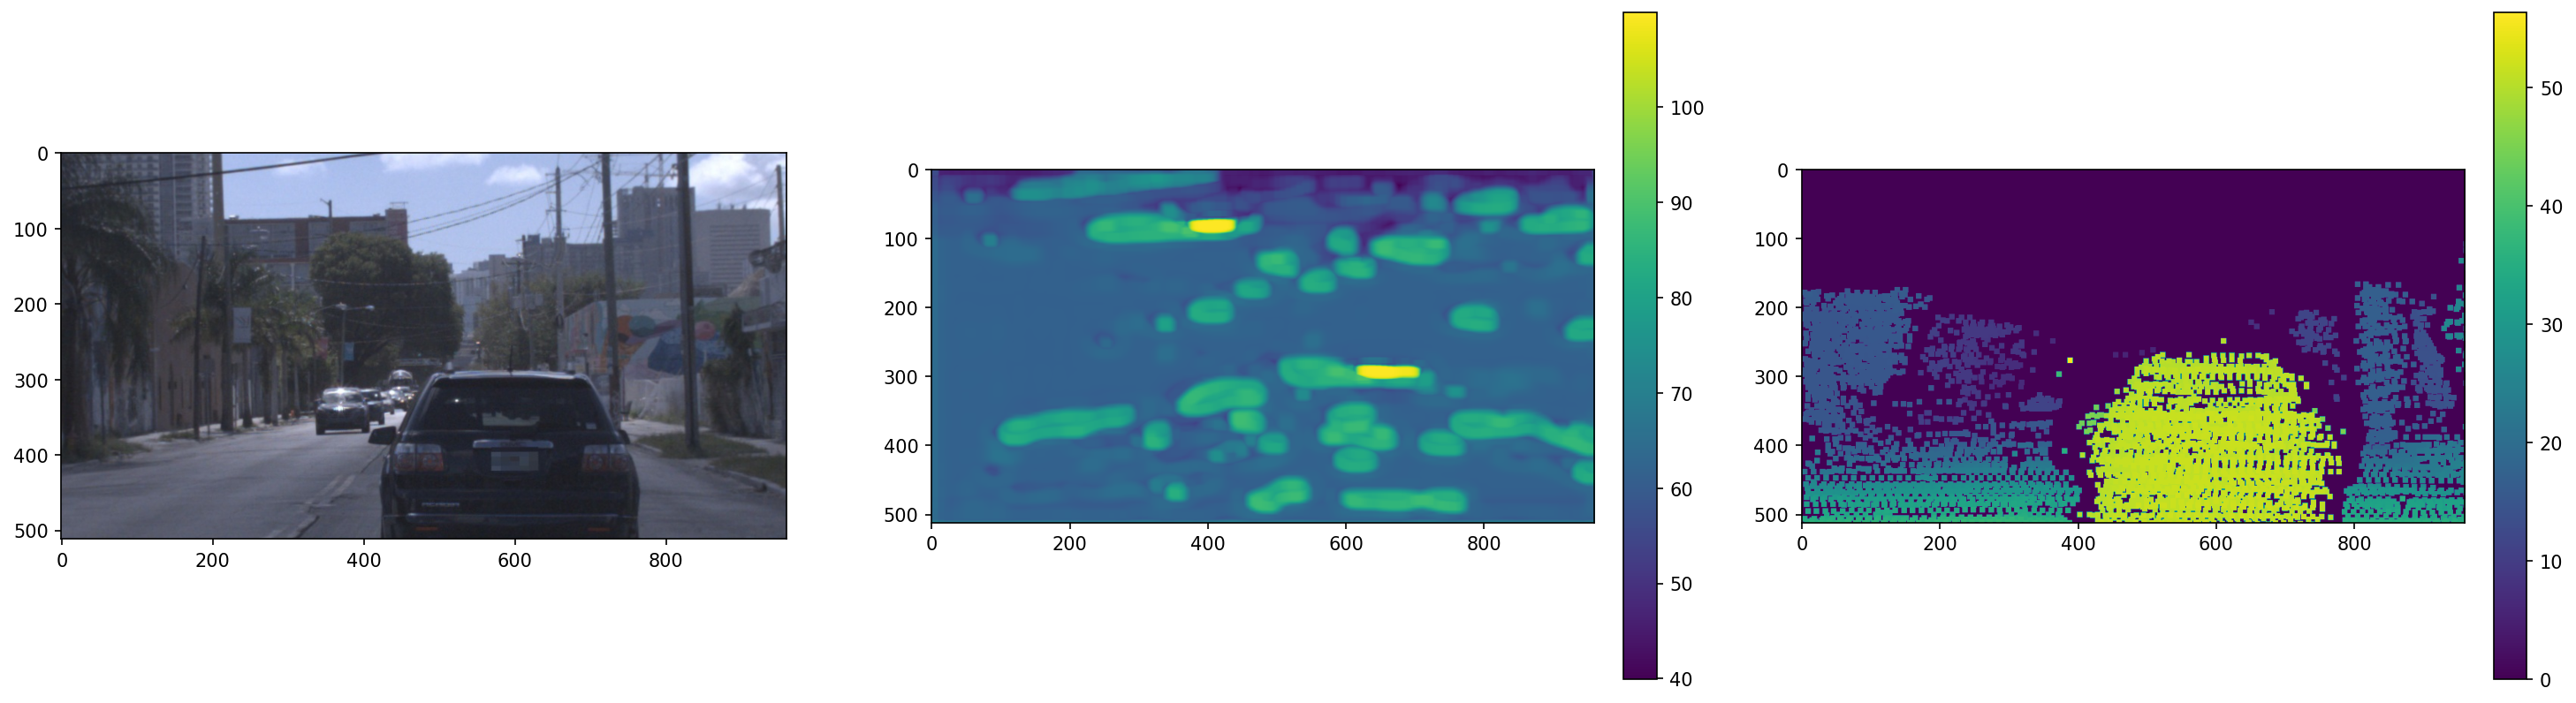

In [31]:
#Can test a single instance this way
state_dict = torch.load('trained_mobilenet/checkpoint_000003.ckpt')
model.load_state_dict(state_dict['model'])
pred, truth = test_single_instance(10, argoverse_ds_test)

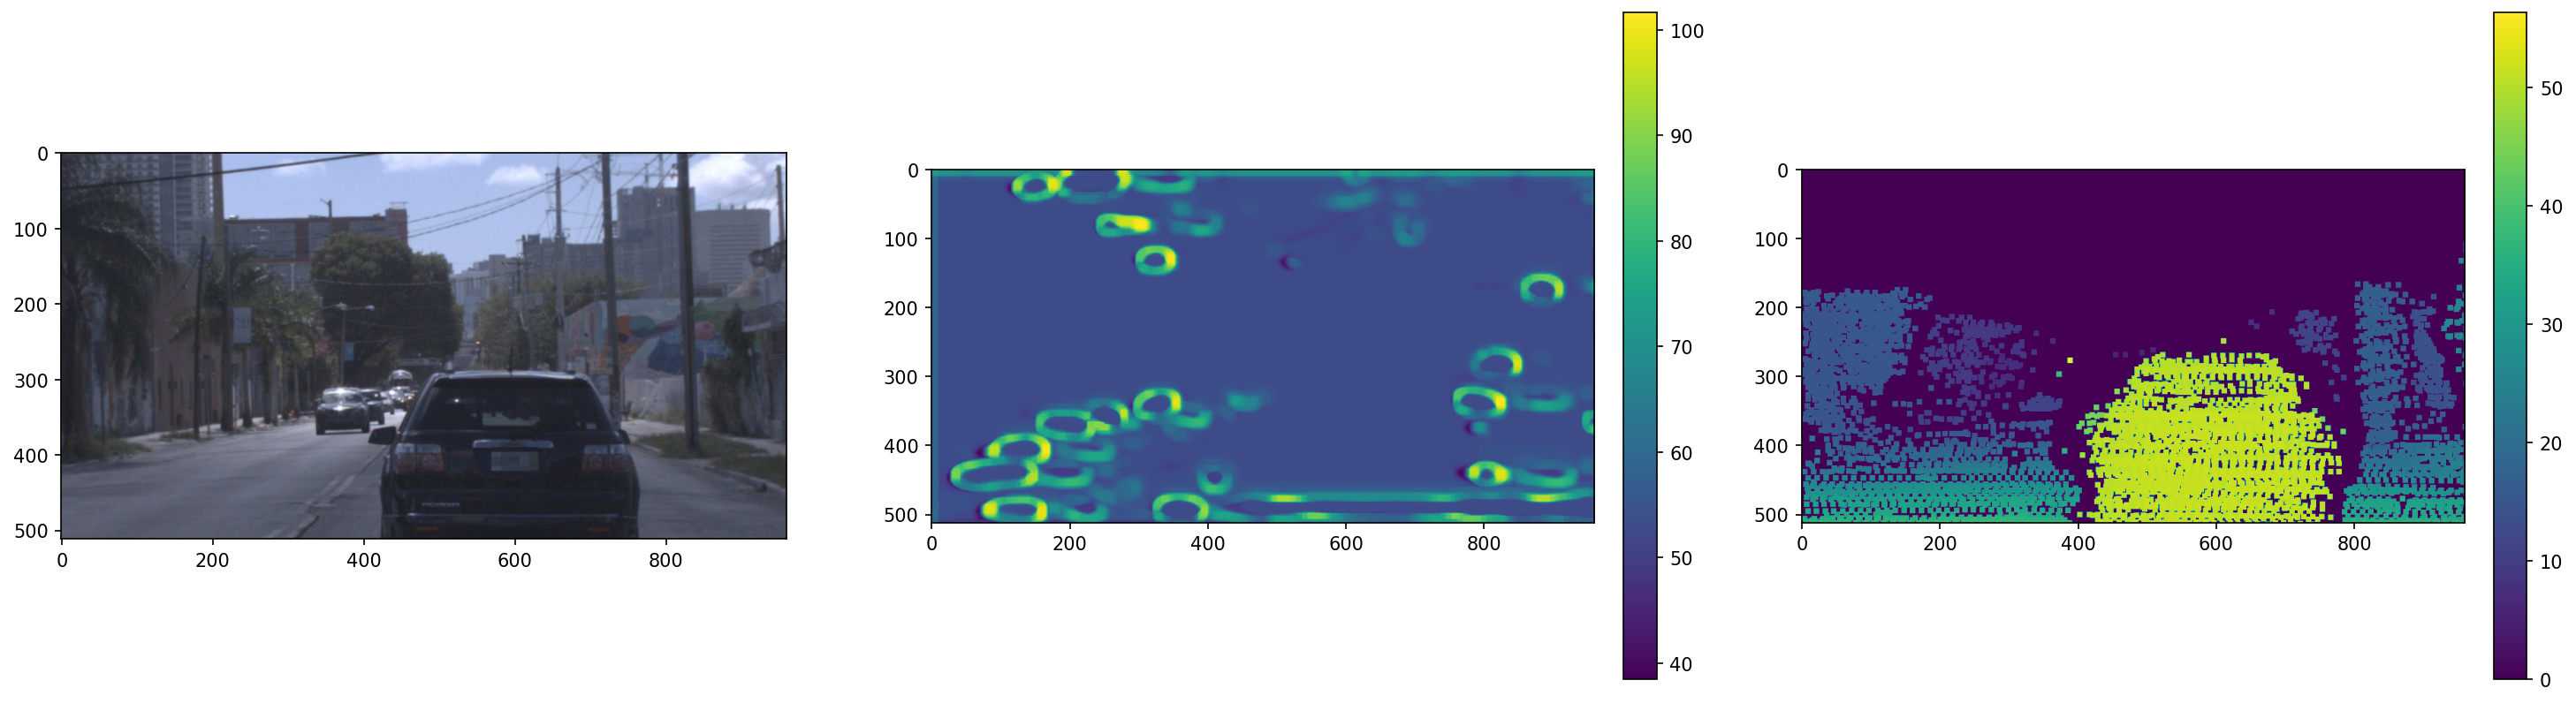

## Now evaluate!

In [36]:
results_path, pred_path, truth_path, truth_obj_path, ref_img_path = test(TestImgLoader)

Batch  10 out of  1522
Inference time:  13.093615293502808 running average:  13.947150143710049 total run-time:  155.64153814315796
Batch  11 out of  1522


In [ ]:

#Create save dir for disparity error images:
disp_err_path = os.path.join(results_path, 'disparity_err_img')
os.makedirs(disp_err_path, exist_ok=True)
#Convert to aboslute paths:
pred_path = Path(os.path.abspath(pred_path))
outer_truth_path = Path(os.path.abspath(os.path.join(truth_path, '..')))
disp_err_path = Path(os.path.abspath(disp_err_path))


#Create stereo evaluator:
evaluator = StereoEvaluator(
    pred_path, 
    outer_truth_path, 
    disp_err_path,
    save_disparity_error_image=True,
    num_procs=-1
)
#Evaluate:
metrics = evaluator.evaluate() 

print(metrics[0])

{'all:10': 86.65439287549238, 'fg:10': 86.65520206362855, 'bg:10': 86.45833333333334, 'all*:10': 86.65439287549238, 'fg*:10': 86.65520206362855, 'bg*:10': 86.45833333333334, 'all:5': 97.15276588456928, 'fg:5': 97.15821152192605, 'bg:5': 95.83333333333334, 'all*:5': 97.15276588456928, 'fg*:5': 97.15821152192605, 'bg*:5': 95.83333333333334, 'all:3': 97.15276588456928, 'fg:3': 97.15821152192605, 'bg:3': 95.83333333333334, 'all*:3': 97.15276588456928, 'fg*:3': 97.15821152192605, 'bg*:3': 95.83333333333334}


In [ ]:
#The following only works if you have a GPU setup. I do not-but it does something simlar to what's 
#already been impelmented

import torchvision
#Using argoverse's stereo loader thing:
data_dir = Path("/media/sf_shared/data")
output_dir = os.path.join(os.path.abspath('./'), 'evaluation')
os.makedirs(output_dir, exist_ok=True)

#Define the transforms you want:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(512, 960)),
        torchvision.transforms.Normalize(
            mean=(0.485, 0.456, 0.406),  # ResNet mean image normalization
            std=(0.229, 0.224, 0.225),  # ResNet std image normalization
        ),
    ]
)
from argoverse.evaluation.stereo.generate_stereo_results import generate_stereo_results

#Fails because of no cude device
generate_stereo_results(model, data_dir, output_dir, transforms)
metrics = evaluator.evaluate()
print(f"{json.dumps(metrics, sort_keys=False, indent=4)}")
